In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import math
import cv2
import os
import keras.backend as K
from google.colab import drive
from keras import backend as K
from keras.layers import Layer
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPool2D, AveragePooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
# use GPU

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [19]:
# import dataset

drive.mount('/content/drive')
os.chdir("/content/drive/My Drive")

labels = ['Dunia Fantasi', 'Kebun Binatang Ragunan', 'Kota Tua', 'Lubang Buaya', 'Monumen Nasional',
          'Pulau Tidung', 'Sea World Ancol', 'Taman Impian Jaya Ancol', 'Taman Mini Indonesia Indah (TMII)', 'Transera Waterpark']
img_size = 150
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1]
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

train = get_data("/content/drive/MyDrive/Image Classification/Training")
test = get_data("/content/drive/MyDrive/Image Classification/Testing")

X_train = []
y_train = []
X_test = []
y_test = []

for feature, label in train:
  X_train.append(feature)
  y_train.append(label)

for feature, label in test:
  X_test.append(feature)
  y_test.append(label)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-19-b02a2969e635>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [20]:
# normalize data

X_train = np.array(X_train) / 255
X_train = X_train.reshape(-1, img_size, img_size, 3)
X_train = X_train.astype('float32')
y_train = np.array(y_train)
y_train = to_categorical(y_train)

X_test = np.array(X_test) / 255
X_test = X_test.reshape(-1, img_size, img_size, 3)
X_test = X_test.astype('float32')
y_test = np.array(y_test)
y_test = to_categorical(y_test)

In [21]:
X_train.shape

(2400, 150, 150, 3)

In [22]:
y_train.shape

(2400, 10)

In [23]:
# inception module

def inception_module(x,filters_a,
                     filters_b1,filters_b2,
                     filters_c1,filters_c2,
                     filters_d1,filters_d2,
                     filters_pool_proj,name=None):
  conv_a = Conv2D(filters_a, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
  conv_b = Conv2D(filters_b1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
  conv_b = Conv2D(filters_b2, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_b)
  conv_c = Conv2D(filters_c1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
  conv_c = Conv2D(filters_c2, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_c)
  conv_d = Conv2D(filters_d1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
  conv_d = Conv2D(filters_d2, (7, 7), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_d)
  pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)
  output = concatenate([conv_a, conv_b, conv_c, conv_d, pool_proj], axis=3, name=name)
  return output

kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [24]:
# build model

inp = Input(shape=(150, 150, 3))
x = Conv2D(32, (3, 3), padding='same', strides=(1, 1), activation='relu')(inp)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2))(x)
x = inception_module(x,filters_a=32,
                     filters_b1=32,filters_b2=48,
                     filters_c1=32,filters_c2=48,
                     filters_d1=32,filters_d2=48,
                     filters_pool_proj=64)
x = inception_module(x,filters_a=32,
                     filters_b1=32,filters_b2=64,
                     filters_c1=32,filters_c2=64,
                     filters_d1=32,filters_d2=64,
                     filters_pool_proj=80)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2))(x)
x = inception_module(x,filters_a=32,
                     filters_b1=32,filters_b2=80,
                     filters_c1=32,filters_c2=80,
                     filters_d1=32,filters_d2=80,
                     filters_pool_proj=96)
x = inception_module(x,filters_a=32,
                     filters_b1=32,filters_b2=96,
                     filters_c1=32,filters_c2=96,
                     filters_d1=32,filters_d2=96,
                     filters_pool_proj=128)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(10, activation='softmax')(x)
model = Model(inp, x)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_33 (Conv2D)          (None, 150, 150, 32)         896       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 75, 75, 32)           0         ['conv2d_33[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_35 (Conv2D)          (None, 75, 75, 32)           1056      ['max_pooling2d_6[0][0]'

In [26]:
batch_size = 60
epochs = 300
data_augmentation = True
initial_lrate = 0.0001

def decay(epoch, steps=100):
  initial_lrate = 0.0001
  drop = 0.96
  epochs_drop = 8
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate

opt = Adam(lr=initial_lrate)
lr_sc = LearningRateScheduler(decay, verbose=1)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
H = model.fit(np.array(X_train), np.array(y_train), validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[lr_sc])


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/300
40/40 [==============================] - 29s 448ms/step - loss: 2.3235 - accuracy: 0.1267 - val_loss: 2.2258 - val_accuracy: 0.2983 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/300
40/40 [==============================] - 18s 441ms/step - loss: 2.1141 - accuracy: 0.2358 - val_loss: 1.9632 - val_accuracy: 0.3117 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/300
40/40 [==============================] - 18s 440ms/step - loss: 1.8539 - accuracy: 0.3383 - val_loss: 1.7078 - val_accuracy: 0.4083 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/300
40/40 [==============================] - 18s 445ms/step - loss: 1.6718 - accuracy: 0.3979 - val_loss: 1.5340 - val_accuracy: 0.4583 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/300
40/40 [============

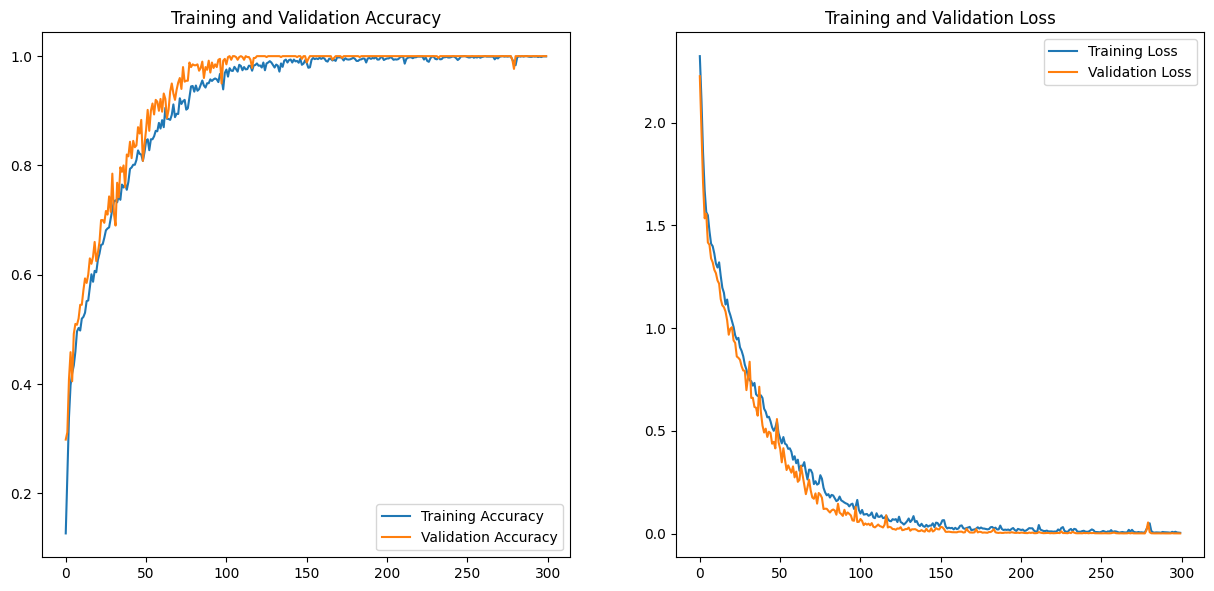

In [28]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

predictions_x=model.predict(X_test)
classes_x=np.argmax(predictions_x,axis=1)

y_test=np.argmax(y_test,axis=1)

print(classification_report(y_test, classes_x, target_names = ['Dunia Fantasi', 'Kebun Binatang Ragunan', 'Kota Tua', 'Lubang Buaya', 'Monumen Nasional',
          'Pulau Tidung', 'Sea World Ancol', 'Taman Impian Jaya Ancol', 'Taman Mini Indonesia Indah (TMII)', 'Transera Waterpark']))

19/19 [==============================] - 1s 60ms/step
                                   precision    recall  f1-score   support

                    Dunia Fantasi       1.00      1.00      1.00        60
           Kebun Binatang Ragunan       1.00      1.00      1.00        60
                         Kota Tua       1.00      1.00      1.00        60
                     Lubang Buaya       1.00      1.00      1.00        60
                 Monumen Nasional       1.00      1.00      1.00        60
                     Pulau Tidung       1.00      1.00      1.00        60
                  Sea World Ancol       1.00      1.00      1.00        60
          Taman Impian Jaya Ancol       1.00      1.00      1.00        60
Taman Mini Indonesia Indah (TMII)       1.00      1.00      1.00        60
               Transera Waterpark       1.00      1.00      1.00        60

                         accuracy                           1.00       600
                        macro avg       1.00

In [30]:
cm = confusion_matrix(y_test, classes_x)
cm

array([[60,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 60,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 60,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 60,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 60,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 60,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 60,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 60,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 60,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 60]])

In [31]:
# Mendapatkan nilai akurasi pelatihan dan pengujian (testing)
train_accuracy = H.history['accuracy']
test_accuracy = H.history['val_accuracy']

# Mencetak nilai akurasi pelatihan dan pengujian (testing)
print("Train Accuracy:", train_accuracy[-1])
print("Test Accuracy:", test_accuracy[-1])

Train Accuracy: 0.9995833039283752
Test Accuracy: 1.0


In [32]:
# to save this model

model.save('Identifying Images.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
